In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import random
sns.set(font_scale = 5)
color_pal = sns.color_palette("colorblind", 6).as_hex()
colors = ','.join(color_pal)

def clear_all(): 
    plt.clf()
    plt.cla()
    plt.close()
    
def plot_and_save(df_orig, dataset_name, embedding_dim): 
    clear_all()
    dataset = df_orig[(df_orig.dataset == dataset_name) & (df_orig.dimensions == embedding_dim)]
    plt.figure(figsize=(30,20))

    ax = sns.barplot(x="algo", y="accuracy(%)", hue="poison", palette="colorblind", data=dataset)
    ax.legend(loc="upper center")
    ax.set(xlabel='Algorithm', ylabel='Accuracy (%)')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    
    if "dd_sq" in dataset_name: 
        n_dataset_name = "Double Density Squares"
    else: 
        n_dataset_name = dataset_name
    ax.set_title(n_dataset_name.capitalize() + " $\mathbb{R}^" + str(embedding_dim) + "$")
    plt.savefig(f"figs/OE/{dataset_name}_{embedding_dim}d.png")


def plot_and_save_ml(df_origin, name):
    clear_all()
    plt.figure(figsize=(30,20))
    dataset_accuracy = df_origin["accuracy(%)"]
    ax = sns.barplot(x="algorithm", y="accuracy(%)", data=df_origin[df_origin.dataset==name],palette="colorblind", ci=None)
    ax.legend(loc="upper center")
    ax.set(xlabel='Algorithm', ylabel='Accuracy (%)')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_ylim(dataset_accuracy.min() - 5, 100)
    ax.set_title(name)
    plt.savefig(f"figs/ML/{name}.png")

def rename_lloc(row): 
    if "lloc" in row["algorithm"]: 
        return f"lloc\n({row.type})"
    else: 
        if "knn" in row["algorithm"]: 
            return f"knn\n(baseline)"
        else: 
            return row["algorithm"]

In [20]:
df = pd.read_csv("./results_other_oe.csv")
df_mine = pd.read_csv("./results.csv")

In [21]:
df.head()

df_mine["accuracy(%)"] = (1 - df_mine.error)*100
df_mine["buckets"] = pd.Series(1 / df_mine.eps, dtype=np.int16)
df_mine["d_algo"] = df_mine["dimensions"].map("lloc_{}d".format) 
df_mine["algo"] = pd.Series("LLOC", range(len(df_mine.buckets)))
df_mine = df_mine[df_mine.ttest_split == 0.3]
df_mine = df_mine[["algo","dataset", "dimensions", "poison", "accuracy(%)", "buckets", "d_algo"]]


In [22]:
cnt = df_mine[df_mine["accuracy(%)"] == 0.0]
cnt.size / df_mine.size

0.03937270603937271

In [23]:
df = df[(df.dimensions == 2) | (df.dimensions==1)]
df["algo"] = df.algo.map(lambda x: x.lower())
df["d_algo"] = df[["dimensions", "algo"]].apply(lambda x: x["algo"] + "_" + str(x["dimensions"]) + "d", axis=1) 
df["buckets"] = pd.Series(0, range(len(df["algo"])))
df = df[["algo","dataset", "dimensions", "poison", "accuracy(%)", "buckets", "d_algo"]]
df["algo"] = df["algo"].map(lambda x: x.upper())
df.head()

,algo,dataset,dimensions,poison,accuracy(%),buckets,d_algo
0,LOE,random,2,0.0,67.228464,0.0,loe_2d
1,LOE,random,2,0.0,62.228464,0.0,loe_2d
2,LOE,random,2,0.0,68.228464,0.0,loe_2d
3,LOE,random,2,0.0,62.228464,0.0,loe_2d
4,SOE,random,2,0.0,70.224719,0.0,soe_2d


In [24]:
df_joined = pd.concat([df, df_mine])
#df_joined = df_joined.sort_values('algo', ascending = False).reset_index(drop=True)
df_joined["poison"] = df_joined["poison"].map(lambda x: str(int(x * 100)) + "%")
#df_joined = df_joined.sort_values('poison', ascending = True).reset_index(drop=True)
df_joined = df_joined.sort_values(by=["algo", "poison"], key=lambda col: col.str.lower())
df_joined = df_joined[df_joined["accuracy(%)"] > 20]

In [25]:
datasets = df_joined["dataset"].unique()
dimensions = df_joined["dimensions"].unique()

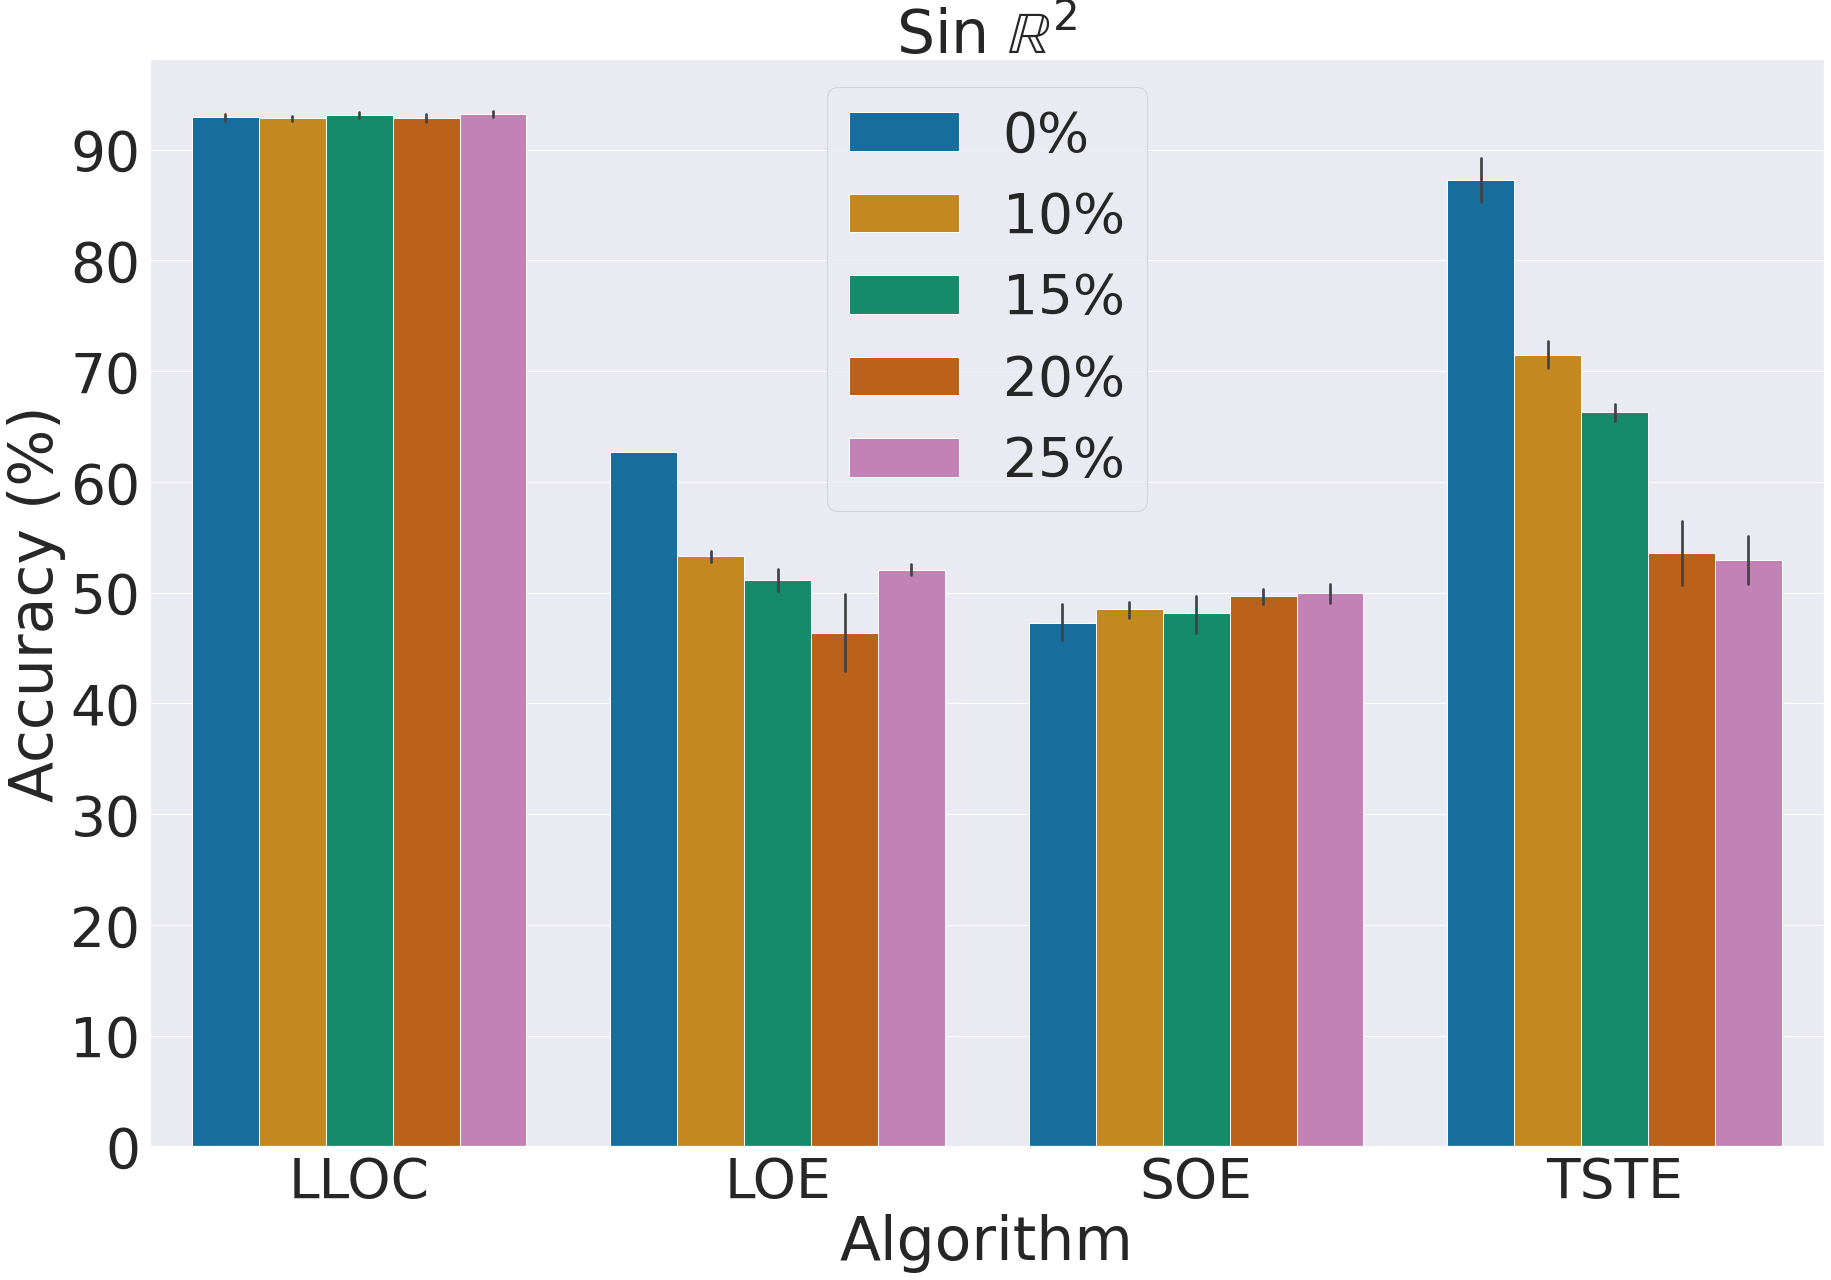

In [26]:
for ds in datasets: 
    for dim in dimensions: 
        plot_and_save(df_joined, ds, dim)

In [27]:
results_ml = pd.read_csv("results_metric_learning.csv")
results_metric_learning_lptml = pd.read_csv("results_metric_learning_lptml.csv")
results_metric_learning_lptml["accuracy(%)"] = (1 - results_metric_learning_lptml.error)*100
results_metric_learning_lptml = results_metric_learning_lptml[["dataset","algorithm","accuracy(%)", "type","dimensions"]]
results_metric_learning_lptml = results_metric_learning_lptml[["dataset","algorithm","accuracy(%)", "type","dimensions"]]
results_ml = results_ml[["dataset","algorithm","accuracy(%)", "type","dimensions"]]
results_metric_learning_lptml


,dataset,algorithm,accuracy(%),type,dimensions
0,iris,MMC,96.8,NaN,NaN
1,iris,LSML,96.0,NaN,NaN
2,iris,ITML,97.0,NaN,NaN
3,iris,NCA,94.9,NaN,NaN
4,iris,MLKR,95.0,NaN,NaN
...,...,...,...,...,...
67,breast_cancer_poisoned,MLKR,92.4,NaN,NaN
68,breast_cancer_poisoned,LFDA,91.9,NaN,NaN
69,breast_cancer_poisoned,LMNN,91.2,NaN,NaN
70,breast_cancer_poisoned,GMML,91.3,NaN,NaN


In [31]:
all_results_ml = pd.concat([results_ml,results_metric_learning_lptml])
all_results_ml["algorithm"] = all_results_ml[["algorithm","type"]].apply(lambda x: rename_lloc(x),axis=1) 
all_results_ml = all_results_ml[(all_results_ml.algorithm != "NCA") & (all_results_ml.algorithm != "MMC")]

In [32]:
all_results_ml.head()


all_results_ml["dataset"] = all_results_ml["dataset"].map(lambda x: " ".join([a.capitalize() for a in x.split("_")]))
all_results_ml[all_results_ml.algorithm == "NCA"]

,dataset,algorithm,accuracy(%),type,dimensions


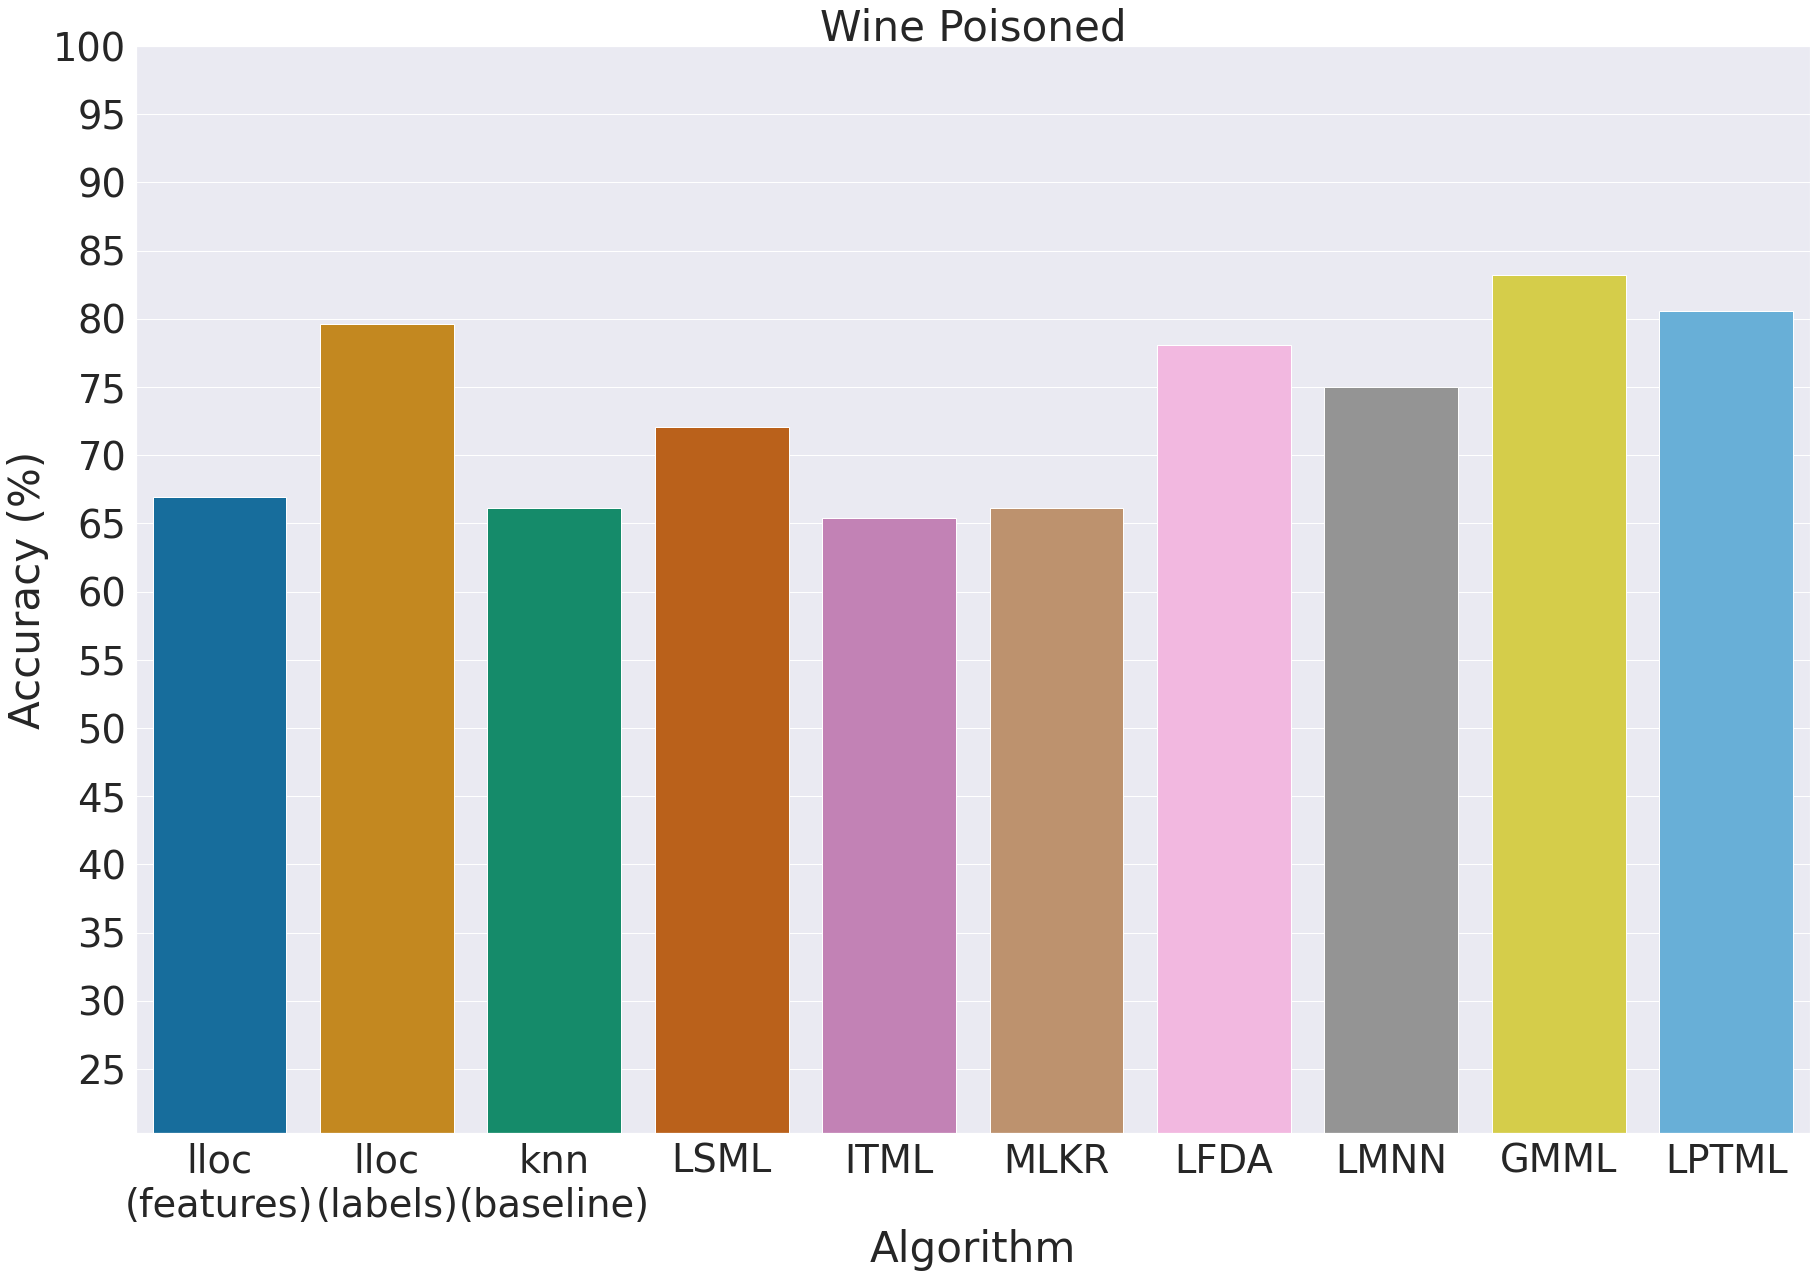

In [33]:
datasets = all_results_ml.dataset.unique()
for ds in datasets: 
    plot_and_save_ml(all_results_ml, ds)


In [14]:
results_ml[results_ml.algorithm == "knn"]

,dataset,algorithm,accuracy(%),type,dimensions
40,synthetic,knn,63.333333,NaN,NaN
41,soybean_real,knn,80.459770,NaN,NaN
42,iris,knn,97.777778,NaN,NaN
43,wine,knn,72.222222,NaN,NaN
44,ionosphere,knn,87.735849,NaN,NaN
45,breast_cancer,knn,96.190476,NaN,NaN
46,ionosphere_poisoned,knn,82.758621,NaN,NaN
47,wine_poisoned,knn,66.101695,NaN,NaN
48,iris_poisoned,knn,86.000000,NaN,NaN
49,breast_cancer_poisoned,knn,88.888889,NaN,NaN


In [297]:
results_metric_learning_lptml.algorithm.unique()

array(['MMC', 'LSML', 'ITML', 'NCA', 'MLKR', 'LFDA', 'LMNN', 'GMML',
       'LPTML'], dtype=object)

In [321]:
datasets

array(['Breast Cancer', 'Ionosphere', 'Ionosphere Poisoned', 'Iris',
       'Iris Poisoned', 'Soybean Real', 'Synthetic', 'Wine',
       'Wine Poisoned', 'Breast Cancer Poisoned'], dtype=object)